In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.nn import functional as F
from torchvision.utils import make_grid

from swadist.data.loader import get_dataloaders
from swadist.utils import binary_cross_entropy, Trainer, show_imgs
from swadist.models.resnet import ResNet

plt.rcParams["savefig.bbox"] = 'tight'
torch.multiprocessing.set_sharing_strategy('file_system')

torch.__version__

'1.10.2'

In [2]:
cuda = False # torch.cuda.is_available()
print(f'GPU available: {cuda}')

GPU available: False


In [3]:
# load CIFAR-10
loaders = get_dataloaders(dataset="cifar10", num_workers=4, validation_split=True, batch_size=16, cuda=cuda)

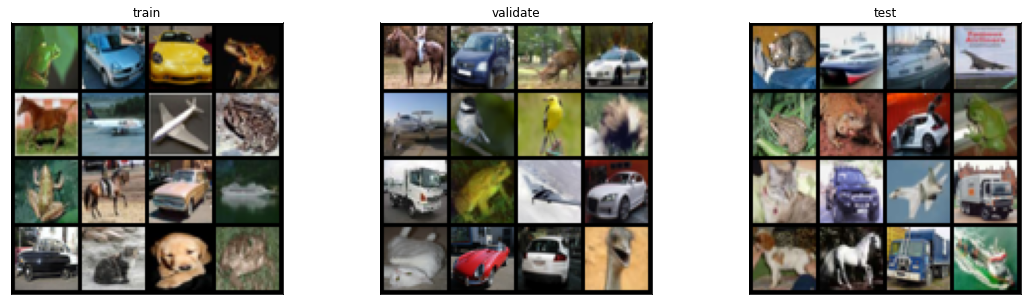

In [4]:
train_grid = make_grid(loaders[0].dataset.inv_transform(next(iter(loaders[0]))[0]), nrow=4)
valid_grid = make_grid(loaders[1].dataset.inv_transform(next(iter(loaders[1]))[0]), nrow=4)
test_grid = make_grid(loaders[2].dataset.inv_transform(next(iter(loaders[2]))[0]), nrow=4)
show_imgs([train_grid, valid_grid, test_grid], titles=['train', 'validate', 'test'])

In [7]:
# hyperparams
epochs, lr0, alpha, T, gamma = 10, 0.01, 2**-6, 7, 0.95
lr_lambda = lambda epoch: 1 - (1 - alpha)*epoch/T if epoch < T else alpha

Adjusting learning rate of group 0 to 1.0000e-02.
Starting training Loop...
Train epoch: 1 -- Avg. epoch loss (cross_entropy): 0.104441 -- Batch: 2813/2813 (100%) -- Total steps: 2813
cross_entropy: 4.268523 -- Accuracy: 0.098842 -- Batch: 313/313 (100%)

Adjusting learning rate of group 0 to 8.5938e-03.
Train epoch: 2 -- Avg. epoch loss (cross_entropy): 0.076928 -- Batch: 2813/2813 (100%) -- Total steps: 5626
cross_entropy: 4.726831 -- Accuracy: 0.099441 -- Batch: 313/313 (100%)

Adjusting learning rate of group 0 to 7.1875e-03.
Train epoch: 3 -- Avg. epoch loss (cross_entropy): 0.064328 -- Batch: 2813/2813 (100%) -- Total steps: 8439
cross_entropy: 5.512759 -- Accuracy: 0.107428 -- Batch: 313/313 (100%)

Adjusting learning rate of group 0 to 5.7812e-03.
Train epoch: 4 -- Avg. epoch loss (cross_entropy): 0.056224 -- Batch: 2813/2813 (100%) -- Total steps: 11252
cross_entropy: 6.376045 -- Accuracy: 0.098642 -- Batch: 313/313 (100%)

Adjusting learning rate of group 0 to 4.3750e-03.


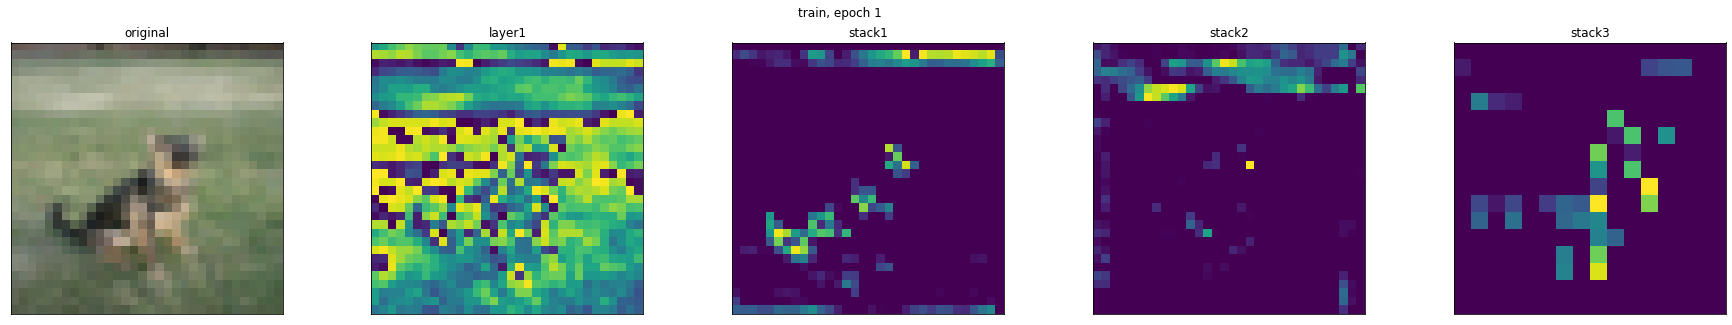

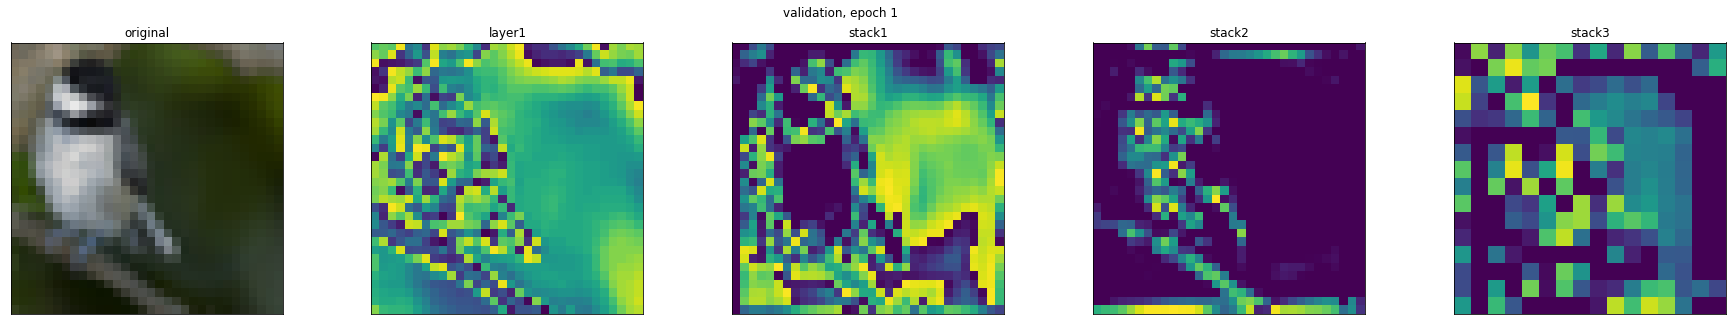

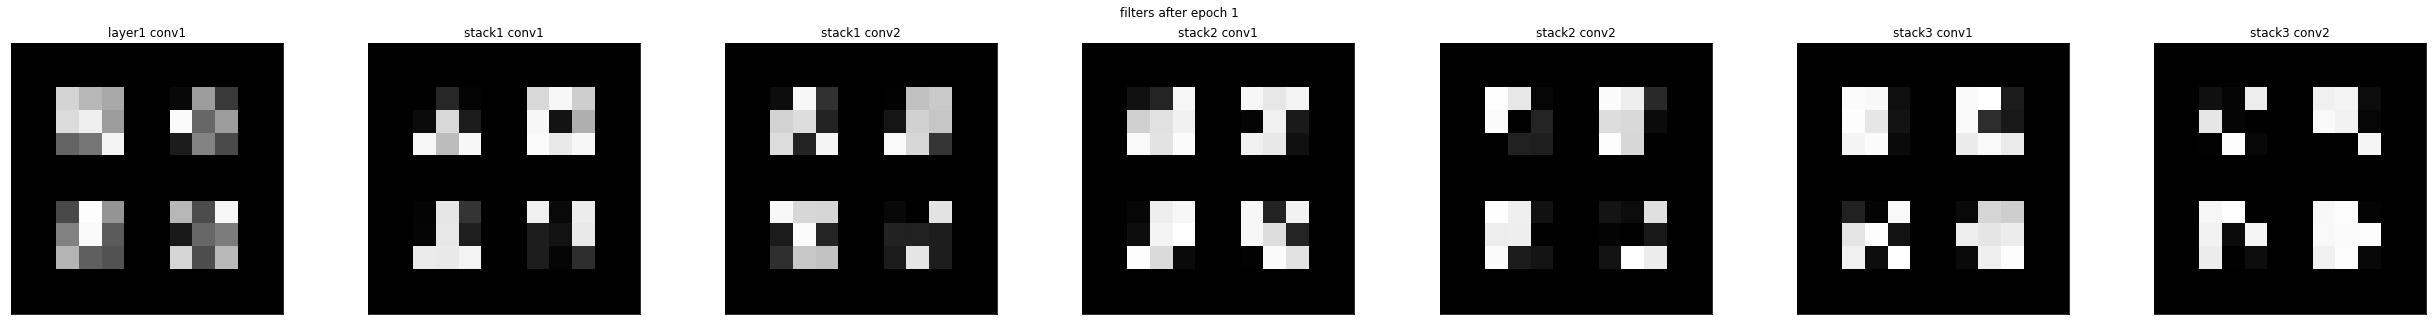

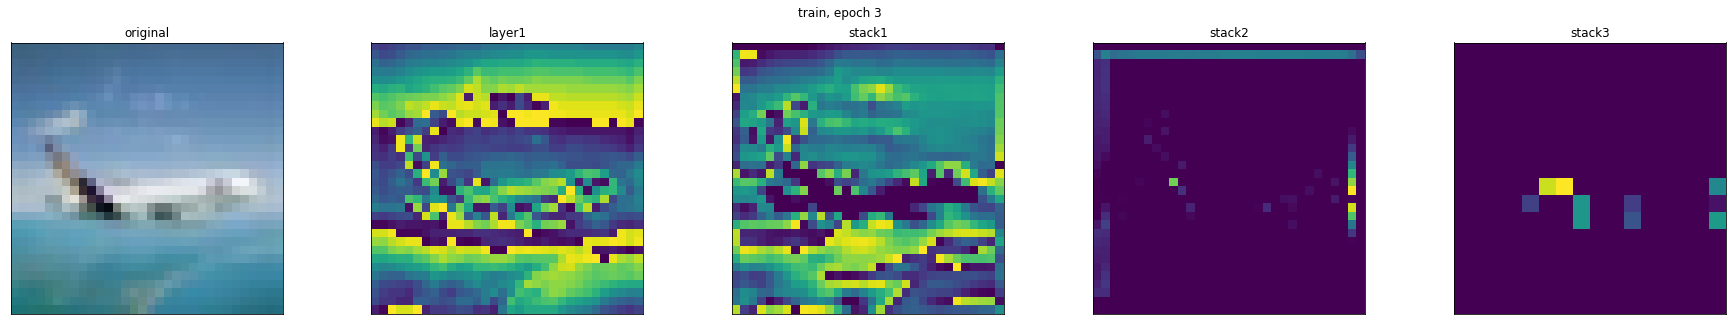

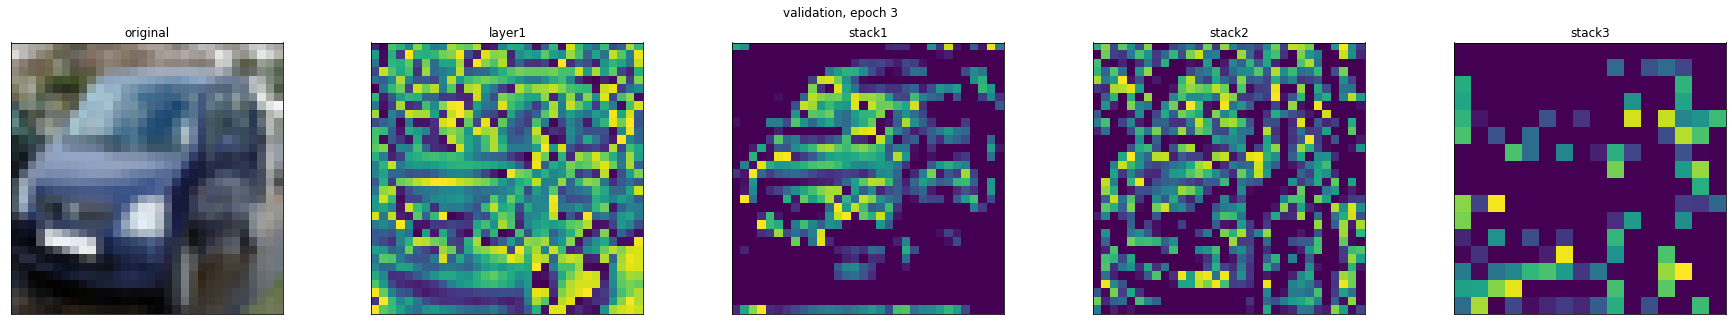

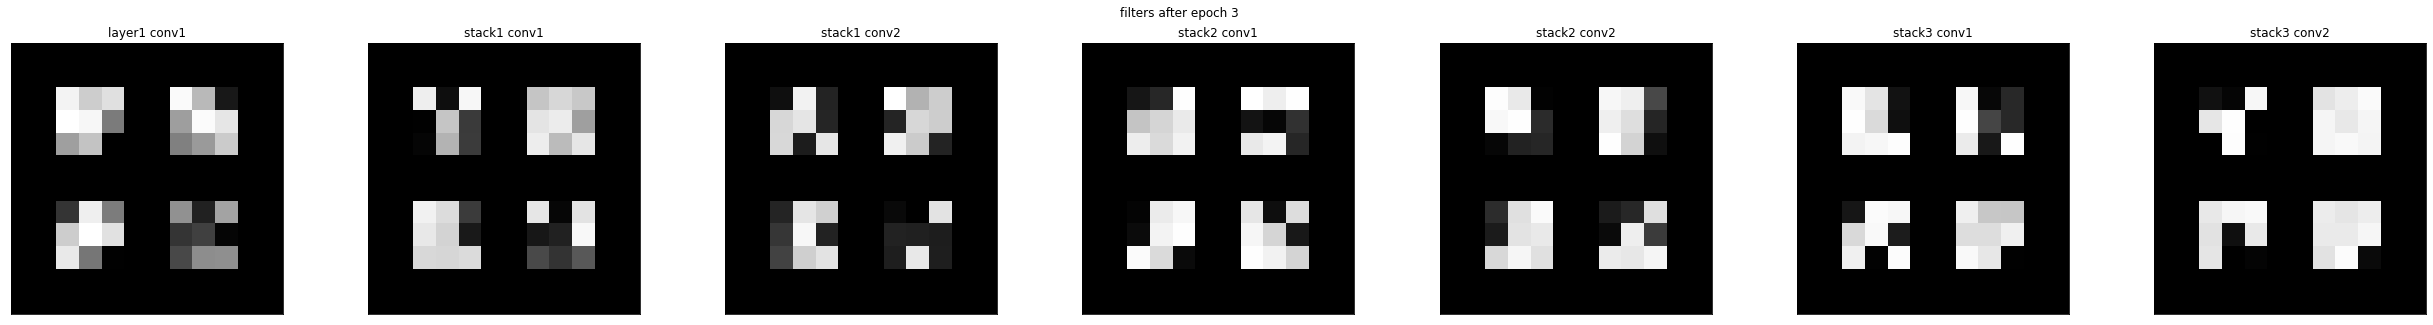

In [8]:
# model
resnet8 = ResNet(in_kernel_size=3, stack_sizes=[1, 1, 1], n_classes=10, batch_norm=False)

optimizer = torch.optim.SGD(resnet8.parameters(), lr=lr0, momentum=gamma, nesterov=True)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, verbose=True)

# begin training
trainer = Trainer(resnet8, F.cross_entropy, optimizer, scheduler, n_plot=2)
trainer(loaders[0], loaders[1], epochs=4)